[[ 1.   0.   0.4]
 [ 0.4  1.   0. ]
 [ 0.  -0.4  1. ]]


Dumb mode: 100%|██████████| 12/12 [00:00<00:00, 37.92it/s]


         [3, 4, 7, 8, 9, 11]
 Top set (3, 4, 7, 8, 9, 11)
     Set (3, 4, 5, 7, 8, 9, 10, 11) : info = 31940.38994617064 penalty 32.280897346502954, sd with highest 0.0
     Set (3, 4, 7, 8, 9, 10, 11) : info = 31940.13675176233 penalty 28.248380888598213, sd with highest 7.12920670109543
     Set (0, 3, 4, 5, 7, 8, 9, 10, 11) : info = 31938.90934321785 penalty 36.28068804325807, sd with highest 6.012551290528865
     Set (0, 3, 4, 5, 6, 7, 8, 9, 10, 11) : info = 31935.724293229756 penalty 40.3085456822463, sd with highest 7.693082908180248
     Set (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11) : info = 31931.80753537413 penalty 44.30840584522322, sd with highest 8.708426700148316
Best Set (3, 4, 7, 8, 9, 11) : info = 31931.77399392004 penalty 24.229330495015947, sd with highest 12.916896185571112
     Set (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11) : info = 31927.817934283692 penalty 48.308402582380154, sd with highest 9.587420422409812
     Set (3, 7, 8, 9, 11) : info = 30384.01144435738 penalty 20

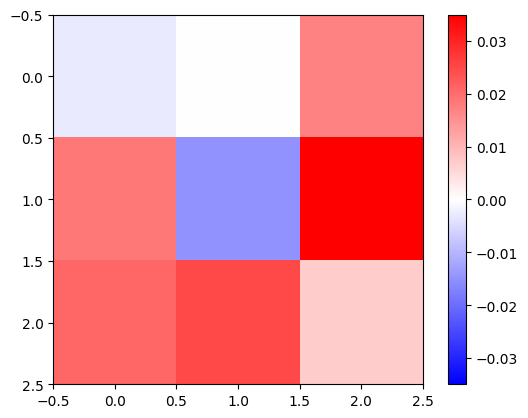

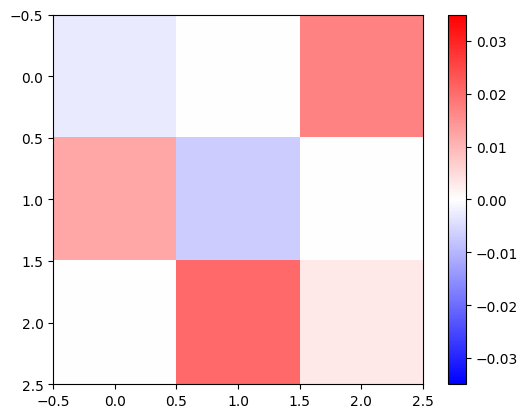

[[ 1.   0.   0.4]
 [ 0.4  1.   0. ]
 [ 0.  -0.4  1. ]]
[[ 1.00289182  0.          0.38292686]
 [ 0.38149315  1.01501266 -0.03494682]
 [-0.02075319 -0.42459429  0.99302209]]
[[ 1.00289182  0.          0.38292686]
 [ 0.38795159  1.00706991  0.        ]
 [ 0.         -0.42042096  0.99679157]]


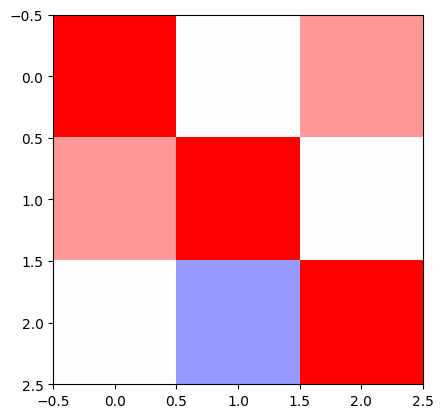

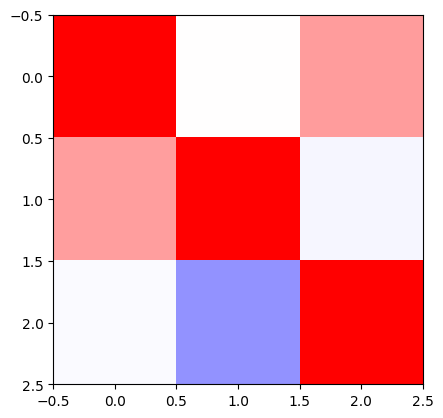

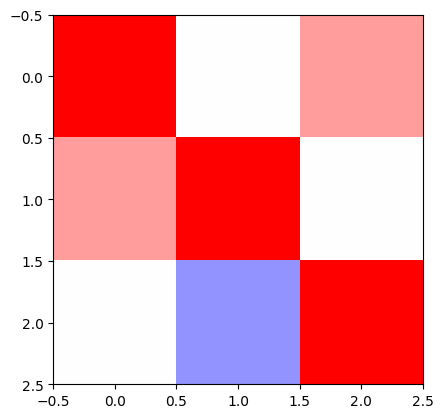

In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
if not dir2 in sys.path: sys.path.append(dir2)

import numpy as np
from simulation_models.Ornstein_Uhlenbeck import OrnsteinUhlenbeck
from SFFI.simulation import simulate
import matplotlib.pyplot as plt
import SFFI.SBR_progression as l
import SFFI.sffi as sffi

    
def simu_for_plotting(model = None):
    if model is None:
        alpha = 0.4
        omega = np.array([
            [1.   , 0.   , alpha],
            [alpha   , 1.   , 0],
            [0  , -alpha   , 1. ]])
        model = OrnsteinUhlenbeck(omega=omega, diffusion_strength=10, dt=0.01, n=1_000_000)
    model.fast_random = np.random.default_rng(4)
    para_simu = model.get_parameter_simulation()
    x_simu, dt = simulate(**para_simu)
    x_simu_use = x_simu #+ 1 * np.random.normal(size=x_simu.shape)
    total_base = model.total_base
    #time = dt * np.array(list(range(x_simu.shape[0])))
    # for i in range(omega.shape[0]):
    #     plt.plot(time, x_simu[:,i] )#+ 100*i*model.diffusion_strength*model.dt)
    # plt.plot(x_simu)
    # plt.legend()
    inf_1 = sffi.SFFI(total_base, x_simu_use, dt, para_simu["shape_image"][0], use_jax=True)

    model_l0 = l.L0_SBR(inf_1)
    model_l0.systematic_exploration()
    model_l0.best_nodes = model_l0.get_best_dominating_node()
    print("         " + str(model.index_real_base))
    model_l0.print_top_best_nodes(use_name_base=False)
    model_l0.print_best_nodes()
    
    return model_l0, model

def obtain_infered_matrix_and_real_matrix(l_index_base, dim, coefficients):
    infered_matrix = np.zeros((dim, dim))
    for i, index_base in enumerate(l_index_base):
        index_variable = (index_base // dim) - 1
        index_dimension = index_base % dim
        if index_variable != -1: #Not a constant infered
            infered_matrix[index_dimension, index_variable] = -coefficients[i]
    return infered_matrix

model_l0, model = simu_for_plotting()

dim = model.omega.shape[0]
coefficients_model_l0 = model_l0.get_coefficients_model(model_l0.best_nodes)
print(coefficients_model_l0)
matrix_l0_AICF = obtain_infered_matrix_and_real_matrix(model_l0.best_nodes, dim, coefficients_model_l0)
diff_matrix = (model.omega - matrix_l0_AICF)
## Divide diff_matrix by the maximum of the absolute value between the two matrices for each scalar in matrix
print(np.maximum(np.abs(model.omega), np.abs(matrix_l0_AICF)))
diff_matrix = diff_matrix #/ np.maximum(np.abs(model.omega), np.abs(matrix_l0_AICF))
## Replace nan by 0
diff_matrix_AICF = np.nan_to_num(diff_matrix)


model_l0.selectivity = 0
model_l0.best_nodes = model_l0.get_best_nodes()
print("         " + str(model.index_real_base))
print("         " + str(model_l0.best_nodes))
coefficients_model_l0 = model_l0.get_coefficients_model(model_l0.best_nodes)
matrix_l0_AIC = obtain_infered_matrix_and_real_matrix(model_l0.best_nodes, dim, coefficients_model_l0)
diff_matrix = (model.omega - matrix_l0_AIC)
## Divide diff_matrix by the maximum of the absolute value between the two matrices for each scalar in matrix
diff_matrix = diff_matrix #/ np.maximum(np.abs(model.omega), np.abs(matrix_l0_AIC))
## Replace nan by 0
diff_matrix_AIC = np.nan_to_num(diff_matrix)
print(diff_matrix_AIC)

plt.figure()
vmin = min(diff_matrix_AIC.min(), diff_matrix_AICF.min())
vmax = max(diff_matrix_AIC.max(), diff_matrix_AICF.max())
v = max(abs(vmin), abs(vmax))
vmin = -v
vmax = v
im = plt.imshow(diff_matrix_AIC, cmap='bwr', interpolation=None, vmin=vmin, vmax=vmax)
plt.colorbar(im)
plt.show()
plt.figure()
im = plt.imshow(diff_matrix_AICF, cmap='bwr', interpolation=None, vmin=vmin, vmax=vmax)
plt.colorbar(im)
plt.show()

print(model.omega)
print(matrix_l0_AIC)
print(matrix_l0_AICF)
im_1 = plt.imshow(model.omega, cmap='bwr', interpolation=None, vmin=-1, vmax=1)
plt.colorbar(im)
plt.show()
im = plt.imshow(matrix_l0_AIC, cmap='bwr', interpolation=None,vmin=-1, vmax=1)
plt.colorbar(im_1)
plt.show()
plt.figure()
im = plt.imshow(matrix_l0_AICF, cmap='bwr', interpolation=None, vmin=-1, vmax=1)
plt.colorbar(im_1)
plt.show()